Multi Layer Perceptron @ Bengio

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
words = open(file="names.txt", mode="r").read().splitlines()
words[:5]

['emma', 'olivia', 'ava', 'isabella', 'sophia']

In [3]:
word_len = len(words)
word_len

32033

Building character to index and vice-versa mappings

In [4]:
chars = sorted(list(set("".join(words))))
stoi = {s: i+1 for i, s in enumerate(chars)}
stoi["."] = 0
itos = {i:s for s, i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


Creating the dataset with context window

In [5]:
window = 3

def build_dataset(words):
  X, Y = [], []

  for w in words:
    context = [0] * window
    for ch in w + ".":
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix]

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)

n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

X_train, Y_train = build_dataset(words[:n1])
X_dev, Y_dev = build_dataset(words[n1:n2])
X_test, Y_test = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


Weight and Bias Initialization

In [50]:
n_embed = 10 # character embedding dims (27, n_embed) 27 because we have 27 character classes
n_hidden = 200 # size of the hidden layer

init_gen = torch.Generator().manual_seed(2147483647)

C = torch.randn((vocab_size, n_embed), generator=init_gen)
W1 = torch.randn((n_embed * window, n_hidden), generator=init_gen) * (5/3) / ((n_embed * window)**0.5)
b1 = torch.randn(n_hidden, generator=init_gen) * 0.01
W2 = torch.randn((n_hidden, vocab_size), generator=init_gen) * 0.01
b2 = torch.randn(vocab_size, generator=init_gen) * 0

bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_r = torch.zeros((1, n_hidden))
bnstd_r = torch.ones((1, n_hidden))

params = [C, W1, b1, W2, b2, bngain, bnbias]
print("Parameter count:", sum(p.nelement() for p in params))

for p in params:
  p.requires_grad = True

Parameter count: 12297


Model Training

In [51]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

  # mini-batch
  ix = torch.randint(0, X_train.shape[0], (batch_size,), generator=init_gen)
  X_b, Y_b = X_train[ix], Y_train[ix]

  # forward pass
  embed = C[X_b]
  embedcat = embed.view(embed.shape[0], -1)
  hpreact = embedcat @ W1 + b1
  # BatchNorm layer
  bnmeani = hpreact.mean(0, keepdim=True)
  bnstdi = hpreact.std(0, keepdim=True)
  hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias

  with torch.no_grad():

    bnmean_r = 0.999 * bnmean_r + 0.001 * bnmeani
    bnstd_r = 0.999 * bnstd_r + 0.001 * bnstdi

  h = torch.tanh(hpreact)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, Y_b)

  # backward pass
  for p in params:
    p.grad = None
  loss.backward()

  # update
  lr = 0.1 if i < 100000 else 0.01
  for p in params:
    p.data += -lr * p.grad

  # stats
  if i % 10000 == 0:
    print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")
  lossi.append(loss.log10().item())

      0/ 200000: 3.3147
  10000/ 200000: 2.1984
  20000/ 200000: 2.3375
  30000/ 200000: 2.4359
  40000/ 200000: 2.0119
  50000/ 200000: 2.2595
  60000/ 200000: 2.4775
  70000/ 200000: 2.1020
  80000/ 200000: 2.2788
  90000/ 200000: 2.1862
 100000/ 200000: 1.9474
 110000/ 200000: 2.3010
 120000/ 200000: 1.9837
 130000/ 200000: 2.4523
 140000/ 200000: 2.3839
 150000/ 200000: 2.1987
 160000/ 200000: 1.9733
 170000/ 200000: 1.8668
 180000/ 200000: 1.9973
 190000/ 200000: 1.8347


Plotting loss function

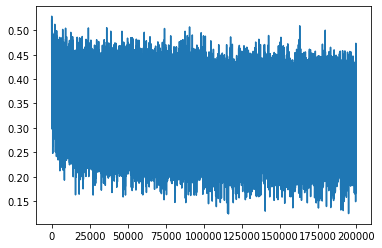

In [53]:
plt.plot(lossi)

In [54]:
@torch.no_grad() # decorator disables gradient tracking
def split_loss(split):
  x, y = {
    'train': (X_train, Y_train),
    'val': (X_dev, Y_dev),
    'test': (X_test, Y_test),
  }[split]

  embed = C[x]
  embedcat = embed.view(embed.shape[0], -1)
  hpreact = embedcat @ W1 + b1
  hpreact = bngain * (hpreact - bnmean_r) / bnstd_r + bnbias
  h = torch.tanh(hpreact)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.06659197807312
val 2.1050572395324707


train: 2.0355966091156006
val: 2.1026782989501953

In [59]:
gen = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):

  out = []
  context = [0] * window
  while True:

    embed = C[torch.tensor([context])]
    h = torch.tanh(embed.view(1, -1) @ W1 + b1)
    logits = h @ W2 + b2
    probs = F.softmax(logits, dim=1)

    ix = torch.multinomial(probs, num_samples=1, generator=gen).item()

    context = context[1:] + [ix]
    out.append(ix)

    if ix == 0:
      break

  print("".join(itos[i] for i in out))

nsxablazhbndevagtobixaibhll.
bjuanthvyahldmoumbignfregh.
susklj.
khel.
brugodggssefgadlaymiezlinyfkllmbygh.
lubbigfernastaphann.
briyasamaylynn.
basislayus.
vihriskldwi.
qulphn.
bdumriessafthn.
brudshthassiagubtd.
rsabby.
ddricsllvyiqaslusssklissidrathlangvaclnnhxaughn.
khmberiss.
fennisehmtmilsasn.
prablavahmbern.
braijnnymarlisukamdyl.
had.
zasdy.


*We need to multiply a factor to the initialized weights and biases such that the input std and weight std are roughly the same. We can do this by multiplying layers with (input)^1/2 (dependent on activation fn). Alternatively, we can initialize using torch.nn.init.kaiming_normal (refer docs)

for inference fix the means and std, bias taken care by batch norm